# Input Data Preparation

In [1]:
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data 

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  # download MNIST data if not exists

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
X_train = mnist.train.images
Y_train = mnist.train.labels
X_validation = mnist.validation.images
Y_validation = mnist.validation.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

train_data_size = mnist.train.num_examples # len(X_train)
print("Training Set  : {0} samples".format(mnist.train.num_examples))
print("Validation Set: {0} samples".format(mnist.validation.num_examples))
print("Test Set      : {0} samples".format(mnist.test.num_examples))

Training Set  : 55000 samples
Validation Set: 5000 samples
Test Set      : 10000 samples


MNIST Image Shape   : (784,)

Reshaped Image Shape   : (28, 28, 1)
Original digit data: 28 x 28   ->   MNIST image size


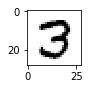

In [5]:
print("MNIST Image Shape   : {0}".format(X_train[0].shape))

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_validation = X_validation.reshape(X_validation.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

print("\nReshaped Image Shape   : {0}".format(X_train[0].shape))

sample_idx = 139  # random.randint(0, mnist.train.num_examples - 1)

print("Original digit data: 28 x 28   ->   MNIST image size")
plt.figure(figsize=(1,1))
plt.imshow(
     mnist.train.images[sample_idx:sample_idx + 1].reshape(28, 28),
     cmap='Greys',
     interpolation='nearest')
plt.show()

Expand Image Size: (32, 32, 1) <- LeNet's Input Size is 32 x 32

Resized digit data: 32 x 32   ->   LeNet input size


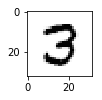

Y (label) data, one-hot style
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [6]:
# zero padding
# pad(data, ((up, down), (left, right)), 'constant')
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Expand Image Size: {} <- LeNet's Input Size is 32 x 32".format(X_train[0].shape))

print("\nResized digit data: 32 x 32   ->   LeNet input size")
plt.figure(figsize=(1.2,1.2))
image = X_train[sample_idx:sample_idx + 1].squeeze()
plt.imshow(
     image,
     cmap='Greys',
     interpolation='nearest')
plt.show()

print("Y (label) data, one-hot style")
print(Y_train[sample_idx:sample_idx + 1])

<br />
# Hyperparameters

In [7]:
learning_rate = 0.001

epoch_size    = 10    # tr data 10번 반복해서 학습
batch_length  = 100   # 1 epoch (tr data 한번 학습) 시 100개씩 배치로 읽어
train_batch_size      = int(mnist.train.num_examples / batch_length)       # 55000 / 100 = 550
validation_batch_size = int(mnist.validation.num_examples / batch_length)  # 5000  / 100 =  50
test_batch_size       = int(mnist.test.num_examples / batch_length)        # 10000 / 100 = 100

input_width   = 32    # resized MNIST data image 32 x 32
input_height  = 32    # resized MNIST data image 32 x 32
input_channel = 1     # MNIST image color: black or white
output_size   = 10    # 0 ~ 9 까지 10개 클래스를 one-hot encoding 값으로 사용할 것

<br />
# Build LeNet-5 Model

In [8]:
def conv_layer(feature_map, filter_size, input_channel, output_channel, stride, padding='VALID', mean=0, stddev=0.1):     
    weight_shape = [filter_size, filter_size, input_channel, output_channel]
    conv_kernel = tf.Variable(tf.truncated_normal(shape=weight_shape, mean=mean, stddev=stddev))
    
    bias_shape = [1, stride, stride,1]
    conv_bias = tf.Variable(tf.random_normal([output_channel]))
    
    conv = tf.nn.conv2d(feature_map, conv_kernel, strides=bias_shape, padding=padding) + conv_bias  
    conv = tf.nn.relu(conv)
    return conv

def pool_layer(feature_map, kernel_size, stride, padding='VALID'):     
    pool = tf.nn.max_pool(feature_map, 
                          ksize  =[1, kernel_size, kernel_size,1], 
                          strides=[1, stride, stride,1], 
                          padding=padding)
    return pool

def fc_layer(input_data, input_size, output_size, mean=0, stddev=0.1):     
    fc_weight = tf.Variable(tf.truncated_normal(shape=[input_size, output_size], mean=mean, stddev=stddev))
    fc_bias = tf.Variable(tf.random_normal([output_size]))
    fc = tf.matmul(input_data, fc_weight) + fc_bias
    fc = tf.nn.relu(fc)  # activation
    return fc

def fc_softmax_layer(input_data, input_size, output_size, mean=0, stddev=0.1):     
    fc_weight = tf.Variable(tf.truncated_normal(shape=[input_size, output_size], mean=mean, stddev=stddev))
    fc_bias = tf.Variable(tf.random_normal([output_size]))
    logits = tf.matmul(input_data, fc_weight) + fc_bias
    h = tf.nn.softmax(logits)  # Hypothesis (using softmax)
    return logits, h


In [9]:
with tf.name_scope('input') as scope:
    X = tf.placeholder(tf.float32, [None, input_width, input_height, input_channel], name='x_input')
    Y = tf.placeholder(tf.float32, [None, output_size], name='y_input')

In [10]:
# Input = 32x32x1. Output = 28x28x6.
with tf.name_scope('conv_layer1') as scope:
    print('conv_layer1', X[0].shape)
    conv1 = conv_layer(X, filter_size=5, input_channel=1, output_channel=6, stride=1)

conv_layer1 (32, 32, 1)


In [11]:
# Input = 28x28x6. Output = 14x14x6.
with tf.name_scope('pooling_layer1') as scope:
    print('conv_layer1', conv1[0].shape)
    pool1 = pool_layer(conv1, kernel_size=2, stride=2)

conv_layer1 (28, 28, 6)


In [12]:
# Input = 14x14x6.. Output = 10x10x16
with tf.name_scope('conv_layer2') as scope:
    conv2 = conv_layer(pool1, filter_size=5, input_channel=6, output_channel=16, stride=1)

In [13]:
# Input = 10x10x16. Output = 5x5x16.
with tf.name_scope('pooling_layer2') as scope:
    pool2 = pool_layer(conv2, kernel_size=2, stride=2)

In [14]:
# Input = 5x5x16. Output = 400x1.
with tf.name_scope('flatten_layer') as scope:
    flattened = tf.contrib.layers.flatten(pool2)

In [15]:
# Input = 400x1. Output = 120x1.
with tf.name_scope('fc_layer1') as scope:
    fc1 = fc_layer(flattened, input_size=400, output_size=120)

In [16]:
# Input = 120x1. Output = 84x1.
with tf.name_scope('fc_layer2') as scope:
    fc2 = fc_layer(fc1, input_size=120, output_size=84)

In [17]:
# Input = 84x1. Output = 10x1.
with tf.name_scope('fc_layer3') as scope:
    logits, h = fc_softmax_layer(fc2, input_size=84, output_size=10)

In [18]:
with tf.name_scope("cost") as scope:
    # cost function: cross entropy cost/loss
    # cost function    L = 1/N * Σ D(S(WXi + b), Li)    cost function L은 loss 의미 
    # cross entropy    D(S, L) = - Σ Li log(Si)         D(S, Li)의 L은 label 의미
    # cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(h), axis = 1))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
    cost = tf.reduce_mean(cross_entropy)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    
    cost_summ = tf.summary.scalar('cost', cost)

In [19]:
with tf.name_scope('accuracy') as scope:
    
    with tf.name_scope('correct_prediction') as scope:
        correct_prediction = tf.equal(tf.argmax(h, 1), tf.argmax(Y, 1))
    with tf.name_scope('correct') as scope:
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    accuracy_summ = tf.summary.scalar("accuracy", accuracy, ['merged_accuracy'])

<br />
# Run Train & Test

#### functions to help batch training/testing

In [20]:
def process_train(data, batch_size, merged_summary, writer, epoch):     
    sum_cost = 0
    for step in range(batch_size):
        batch_x, batch_y = data.next_batch(batch_length)
        batch_x = batch_x.reshape(batch_x.shape[0], 28, 28, 1).astype('float32')
        batch_x = np.pad(batch_x, ((0,0),(2,2),(2,2),(0,0)), 'constant')
                
        summary, cost_res, _ = sess.run([merged_summary, cost, train],
                                      feed_dict = {X: batch_x,
                                                   Y: batch_y})
        
        #writer.add_summary(summary, epoch * batch_size + step)
        sum_cost += cost_res

    return sum_cost / batch_size

def process_validation(data, batch_size, merged_validation_accuracy, writer, epoch):
    sum_accuracy = 0
    for step in range(batch_size):
        batch_x, batch_y = data.next_batch(batch_length)
        batch_x = batch_x.reshape(batch_x.shape[0], 28, 28, 1).astype('float32')
        batch_x = np.pad(batch_x, ((0,0),(2,2),(2,2),(0,0)), 'constant')

        _accuracy = sess.run([accuracy], feed_dict = {X: batch_x, Y: batch_y})
        sum_accuracy += _accuracy[0] * batch_length
        
        merged = sess.run([merged_validation_accuracy],
                feed_dict = {X: batch_x, Y: batch_y})
        
        #writer.add_summary(merged[0], epoch * batch_size + step)

    return sum_accuracy / batch_size

def process_test(data, batch_size):   
    sum_accuracy = 0
    for step in range(batch_size):
        batch_x, batch_y = data.next_batch(batch_length)
        batch_x = batch_x.reshape(batch_x.shape[0], 28, 28, 1).astype('float32')
        batch_x = np.pad(batch_x, ((0,0),(2,2),(2,2),(0,0)), 'constant')

        _accuracy = sess.run([accuracy], feed_dict = {X: batch_x, Y: batch_y})
        sum_accuracy += _accuracy[0] * batch_length

    return sum_accuracy / batch_size

#### start training/testing


Training:

[epoch 01]                cost : 00.481792852 
           validation accuracy : 96.320000529 

[epoch 02]                cost : 00.101589218 
           validation accuracy : 97.600000739 

[epoch 03]                cost : 00.070699629 
           validation accuracy : 97.940001130 

[epoch 04]                cost : 00.054719911 
           validation accuracy : 98.260001063 

[epoch 05]                cost : 00.045999550 
           validation accuracy : 98.340000629 

[epoch 06]                cost : 00.038016677 
           validation accuracy : 98.520001292 

[epoch 07]                cost : 00.032195558 
           validation accuracy : 98.500001192 

[epoch 08]                cost : 00.028294906 
           validation accuracy : 98.680001020 

[epoch 09]                cost : 00.024726508 
           validation accuracy : 98.760001063 

[epoch 10]                cost : 00.020866316 
           validation accuracy : 98.680001140 


Test accuracy:  98.79000091552734


V

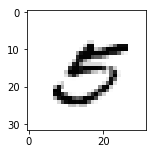

In [21]:
with tf.Session() as sess:
    with tf.name_scope("train") as scope:     
        # tensorboard
        merged_summary = tf.summary.merge_all()
        merged_validation_accuracy = tf.summary.merge_all('merged_accuracy')
        #writer = tf.summary.FileWriter('logs/lenet_5_logs')
        #writer.add_graph(sess.graph)
        writer = []
        
        # initialize tf variables
        sess.run(tf.global_variables_initializer())  
        
        # training cycle
        print("\nTraining:\n")
        for epoch in range(epoch_size):
            
            # a) current epoch's learning
            avg_cost = process_train(
                mnist.train, train_batch_size,
                merged_summary, writer, epoch)
            
            # b) validation accuracy
            validation_accuracy = process_validation(
                mnist.validation, validation_batch_size,
                merged_validation_accuracy, writer, epoch)

            print('[epoch {:02d}]'.format(epoch + 1),
                  '               cost : {:012.9f}'.format(avg_cost), '\n          ',
                  'validation accuracy : {:012.9f}'.format(validation_accuracy) , '\n')
            
    with tf.name_scope("test") as scope:
        test_accuracy = process_test(mnist.test, test_batch_size)
        print("\nTest accuracy: ", test_accuracy)
            
        # Vsualization of a single test
        # randomly get a number and it's predict
        print("\n\nVisualizing a single test")
        r = random.randint(0, mnist.test.num_examples - 1)
        print("answer    : ", sess.run(tf.argmax(Y_test[r:r + 1], 1)))
        print("prediction: ", sess.run(tf.argmax(h, 1),
                                       feed_dict={X: X_test[r:r + 1]}))
        
        plt.figure(figsize=(2.2,2.2))
        image = X_test[r:r + 1].squeeze()
        plt.imshow(
             image,
             cmap='Greys',
             interpolation='nearest')
        plt.show()
        
    